In [27]:
import torch
from ptbxlae.modeling.multiCycleConv import MultiCycleConv

In [28]:
torch.no_grad()
m = MultiCycleConv.load_from_checkpoint('../cache/savedmodels/last-v11.ckpt')
m.eval()

MultiCycleConv(
  (encoder): Sequential(
    (0): Conv1d(12, 24, kernel_size=(13,), stride=(2,), padding=(6,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(24, 48, kernel_size=(13,), stride=(2,), padding=(6,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=60000, out_features=500, bias=True)
  (fc_logvar): Linear(in_features=60000, out_features=500, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=60000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Unflatten(dim=1, unflattened_size=(48, 1250))
    (3): ConvTranspose1d(48, 24, kernel_size=(13,), stride=(2,), padding=(6,), output_padding=(1,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose1d(24, 12, kernel_size=(13,), stride=(2,), padding=(6,), output_padding=(1,))
    (6): LeakyReLU(negative_slope=0.01)
  )
)

In [29]:
from ptbxlae.dataprocessing.ptbxlDS import PtbxlCleanDS

SAMPLE_IDX = 1022

ds = PtbxlCleanDS(root_folder="../data", lowres=False)
sig = ds[SAMPLE_IDX]
sig.shape

torch.Size([12, 5000])

In [30]:
encoded = m.encode(sig.to('cuda').unsqueeze(0))

encoded.squeeze()

tensor([-0.4918,  0.4605,  1.4049, -0.1323,  0.0740,  0.6009,  0.6469,  0.1760,
        -1.2325, -0.9026, -0.0460, -1.1576,  0.0466, -1.8126,  0.2662,  0.7644,
        -0.0706, -0.5167,  0.9316, -0.7786,  0.6562,  0.5047,  1.6338,  1.2256,
         0.1438, -0.2419,  0.0553,  0.4266,  0.0644, -0.1809,  1.2685,  0.9648,
        -1.3540,  0.3917,  0.9660, -0.4130,  0.1332, -0.5815, -1.6021, -0.7908,
         0.2236, -1.1276, -0.6734, -0.0700,  0.2380,  0.3280,  0.2656,  0.6151,
         0.1203, -0.1498,  0.1322, -0.3407,  0.2934,  0.4942,  0.3112,  0.2906,
         0.2301,  0.3992,  0.2673,  0.4934, -0.8666, -0.1727,  0.0466,  1.4575,
         1.3419,  1.2581, -0.5714,  0.6546,  0.8123,  0.9476,  0.6124,  0.5398,
        -0.0243, -0.4842, -1.2337, -1.0044, -0.5053,  1.6433, -0.7107,  0.6480,
        -0.5146, -0.5946,  0.2076, -0.0816,  0.5714,  0.7563, -0.6898, -1.3061,
        -0.3256, -0.1597, -1.1305, -0.7706, -0.8632,  0.6018,  0.7060, -1.3658,
        -0.6312, -1.8221,  2.1073,  0.19

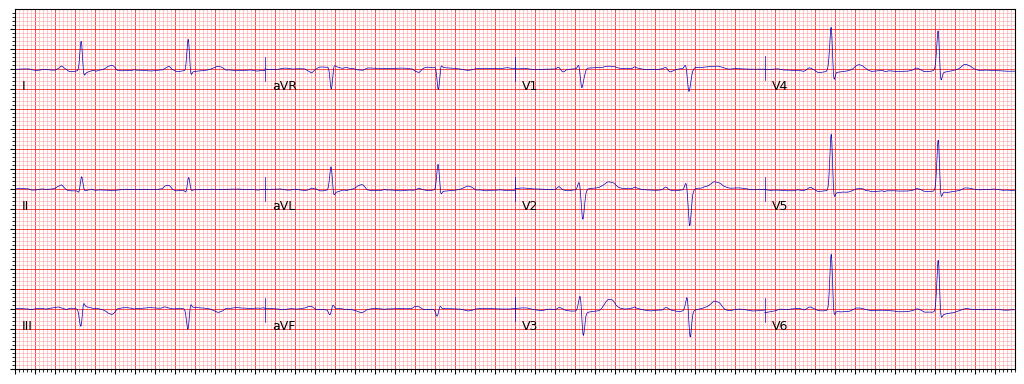

In [31]:
from ptbxlae.dataprocessing import plot_raw_data

# before
plot_raw_data(sig, {'fs': 500})

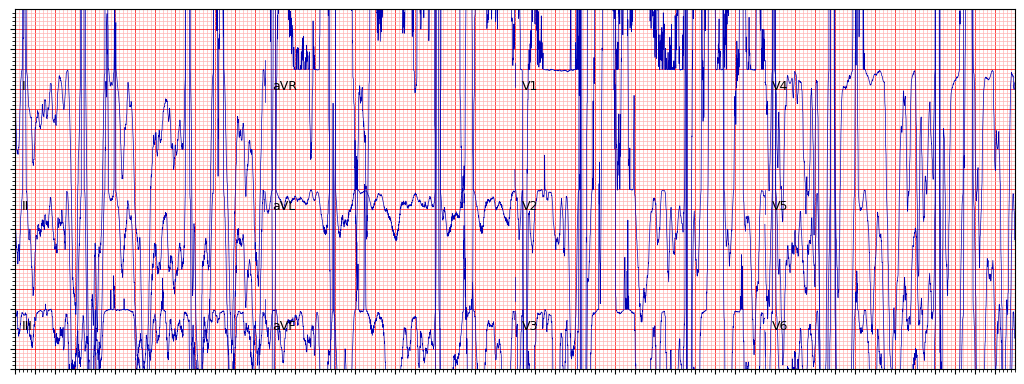

In [32]:
# After
decoded = m.decode(encoded)
plot_raw_data(decoded[0].detach().to('cpu').numpy() * 100, {'fs': 500})

In [23]:
decoded[0,5,:]

tensor([ 0.0284,  0.0276, -0.0005,  ..., -0.0004, -0.0005, -0.0005],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [24]:
sig[5,:]

tensor([0.0078, 0.0081, 0.0083,  ..., 0.0073, 0.0069, 0.0066])

In [25]:
torch.nn.functional.mse_loss(decoded[0,5,:], sig[5,:].to('cuda'))

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)

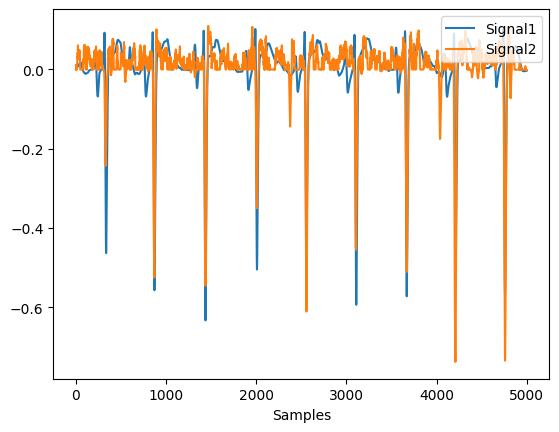

In [26]:
import neurokit2 as nk

#sigproc, info = nk.ecg_process(sig[5], sampling_rate=500)
channel = 6
nk.signal_plot([sig[channel], decoded[0,channel,:].detach().cpu()])